# Test the ENC-DEC model

In [2]:
import numpy as np
import dataloader
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import models
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision
import os
import time
from torch_geometric.nn import GATv2Conv, global_mean_pool
# reload library
import importlib
import cv2
#import utils as ut
import pandas as pd
import DataDLC
from torch_geometric.data import Data, DataLoader
import tqdm


# PyTorch TensorBoard support
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime

In [3]:
importlib.reload(dataloader)
importlib.reload(DataDLC)
importlib.reload(models)

<module 'models' from 'c:\\Users\\jalvarez\\Documents\\Code\\GitHubCOde\\Behavioral_Tagging_of_Mice_in_multiple_Mice_dataset_using_Deep_Learning\\src\\models.py'>

## Load dataset

**Obs:** This is just a test to see if the model is working.

In [4]:
importlib.reload(dataloader)
importlib.reload(DataDLC)

<module 'DataDLC' from 'c:\\Users\\jalvarez\\Documents\\Code\\GitHubCOde\\Behavioral_Tagging_of_Mice_in_multiple_Mice_dataset_using_Deep_Learning\\src\\DataDLC.py'>

In [5]:

dataloader.reload_module()

In [6]:
# Load dataset .pt files
import pickle as pkl


In [130]:
# deactivate warnings
if True:
    import warnings
    warnings.filterwarnings("ignore")


    data_loader = dataloader.DLCDataLoader(r'c:\Users\jalvarez\Documents\Data\DataLoader_Baseline_models', load_dataset=False, batch_size=1, window_size=5, stride=1, build_graph = True, behaviour = 'General_Contacts')


['DMD_mal_Test_10DLC_dlcrnetms5_More_BodyPartsJul9shuffle1_740000_el_filtered.h5', 'DMD_mal_Test_11DLC_dlcrnetms5_More_BodyPartsJul9shuffle1_740000_el_filtered.h5', 'DMD_mal_Test_12DLC_dlcrnetms5_More_BodyPartsJul9shuffle1_740000_el_filtered.h5', 'DMD_mal_Test_13DLC_dlcrnetms5_More_BodyPartsJul9shuffle1_740000_el_filtered.h5', 'DMD_mal_Test_14DLC_dlcrnetms5_More_BodyPartsJul9shuffle1_740000_el_filtered.h5', 'DMD_mal_Test_15DLC_dlcrnetms5_More_BodyPartsJul9shuffle1_740000_el_filtered.h5', 'DMD_mal_Test_16DLC_dlcrnetms5_More_BodyPartsJul9shuffle1_740000_el_filtered.h5', 'DMD_mal_Test_17DLC_dlcrnetms5_More_BodyPartsJul9shuffle1_740000_el_filtered.h5', 'DMD_mal_Test_18DLC_dlcrnetms5_More_BodyPartsJul9shuffle1_740000_el_filtered.h5', 'DMD_mal_Test_19DLC_dlcrnetms5_More_BodyPartsJul9shuffle1_740000_el_filtered.h5', 'DMD_mal_Test_1DLC_dlcrnetms5_More_BodyPartsJul9shuffle1_740000_el_filtered.h5', 'DMD_mal_Test_20DLC_dlcrnetms5_More_BodyPartsJul9shuffle1_740000_el_filtered.h5', 'DMD_mal_Test_21

100%|██████████| 2628/2628 [00:37<00:00, 70.15it/s]


Loading file MDXCV_mal_Test_1DLC_dlcrnetms5_More_BodyPartsJul9shuffle1_740000_el_filtered.h5


100%|██████████| 2620/2620 [00:37<00:00, 70.28it/s]


Loading file DMD_mal_Test_2DLC_dlcrnetms5_More_BodyPartsJul9shuffle1_740000_el_filtered.h5


100%|██████████| 2633/2633 [00:37<00:00, 70.19it/s]


Loading file MDXCV_mal_Test_2DLC_dlcrnetms5_More_BodyPartsJul9shuffle1_740000_el_filtered.h5


100%|██████████| 2626/2626 [00:37<00:00, 70.09it/s]


Loading file DMD_mal_Test_3DLC_dlcrnetms5_More_BodyPartsJul9shuffle1_740000_el_filtered.h5


100%|██████████| 2630/2630 [00:37<00:00, 70.69it/s]


Loading file MDXCV_mal_Test_3DLC_dlcrnetms5_More_BodyPartsJul9shuffle1_740000_el_filtered.h5


100%|██████████| 2625/2625 [00:37<00:00, 70.61it/s]


Loading file DMD_mal_Test_4DLC_dlcrnetms5_More_BodyPartsJul9shuffle1_740000_el_filtered.h5


100%|██████████| 2627/2627 [00:37<00:00, 70.47it/s]


Loading file MDXCV_mal_Test_4DLC_dlcrnetms5_More_BodyPartsJul9shuffle1_740000_el_filtered.h5


100%|██████████| 2629/2629 [00:37<00:00, 70.81it/s]


Loading file DMD_mal_Test_5DLC_dlcrnetms5_More_BodyPartsJul9shuffle1_740000_el_filtered.h5


100%|██████████| 2626/2626 [00:37<00:00, 70.38it/s]


Loading file MDXCV_mal_Test_5DLC_dlcrnetms5_More_BodyPartsJul9shuffle1_740000_el_filtered.h5


100%|██████████| 2630/2630 [00:37<00:00, 70.39it/s]


Loading file DMD_mal_Test_6DLC_dlcrnetms5_More_BodyPartsJul9shuffle1_740000_el_filtered.h5


100%|██████████| 2632/2632 [00:36<00:00, 71.23it/s]


Loading file MDXCV_mal_Test_6DLC_dlcrnetms5_More_BodyPartsJul9shuffle1_740000_el_filtered.h5


100%|██████████| 2631/2631 [00:37<00:00, 70.74it/s]


Loading file DMD_mal_Test_7DLC_dlcrnetms5_More_BodyPartsJul9shuffle1_740000_el_filtered.h5


100%|██████████| 2613/2613 [00:37<00:00, 70.59it/s]


Loading file MDXCV_mal_Test_7DLC_dlcrnetms5_More_BodyPartsJul9shuffle1_740000_el_filtered.h5


100%|██████████| 2628/2628 [00:37<00:00, 70.59it/s]


Loading file DMD_mal_Test_8DLC_dlcrnetms5_More_BodyPartsJul9shuffle1_740000_el_filtered.h5


100%|██████████| 2647/2647 [00:37<00:00, 70.94it/s]


Loading file MDXCV_mal_Test_8DLC_dlcrnetms5_More_BodyPartsJul9shuffle1_740000_el_filtered.h5


100%|██████████| 2631/2631 [00:37<00:00, 70.02it/s]


Loading file DMD_mal_Test_9DLC_dlcrnetms5_More_BodyPartsJul9shuffle1_740000_el_filtered.h5


100%|██████████| 2626/2626 [00:37<00:00, 69.30it/s]


Loading file MDXCV_mal_Test_9DLC_dlcrnetms5_More_BodyPartsJul9shuffle1_740000_el_filtered.h5


100%|██████████| 2629/2629 [00:37<00:00, 70.79it/s]


Loading file DMD_mal_Test_10DLC_dlcrnetms5_More_BodyPartsJul9shuffle1_740000_el_filtered.h5


100%|██████████| 2626/2626 [00:36<00:00, 71.04it/s]


Loading file MDXCV_mal_Test_10DLC_dlcrnetms5_More_BodyPartsJul9shuffle1_740000_el_filtered.h5


100%|██████████| 2629/2629 [00:41<00:00, 63.23it/s]


Loading file DMD_mal_Test_11DLC_dlcrnetms5_More_BodyPartsJul9shuffle1_740000_el_filtered.h5


100%|██████████| 2622/2622 [00:43<00:00, 60.23it/s]


Loading file MDXCV_mal_Test_11DLC_dlcrnetms5_More_BodyPartsJul9shuffle1_740000_el_filtered.h5


100%|██████████| 2629/2629 [00:42<00:00, 61.88it/s]


Loading file DMD_mal_Test_12DLC_dlcrnetms5_More_BodyPartsJul9shuffle1_740000_el_filtered.h5


100%|██████████| 2630/2630 [00:40<00:00, 64.47it/s]


Loading file MDXCV_mal_Test_12DLC_dlcrnetms5_More_BodyPartsJul9shuffle1_740000_el_filtered.h5


100%|██████████| 2631/2631 [00:37<00:00, 70.57it/s]


Loading file DMD_mal_Test_13DLC_dlcrnetms5_More_BodyPartsJul9shuffle1_740000_el_filtered.h5


100%|██████████| 2628/2628 [00:39<00:00, 67.12it/s]


Loading file MDXCV_mal_Test_13DLC_dlcrnetms5_More_BodyPartsJul9shuffle1_740000_el_filtered.h5


100%|██████████| 2635/2635 [00:37<00:00, 70.92it/s]


Loading file DMD_mal_Test_14DLC_dlcrnetms5_More_BodyPartsJul9shuffle1_740000_el_filtered.h5


100%|██████████| 2619/2619 [00:37<00:00, 70.74it/s]


Loading file MDXCV_mal_Test_14DLC_dlcrnetms5_More_BodyPartsJul9shuffle1_740000_el_filtered.h5


100%|██████████| 2618/2618 [00:37<00:00, 70.62it/s]


Loading file DMD_mal_Test_15DLC_dlcrnetms5_More_BodyPartsJul9shuffle1_740000_el_filtered.h5


100%|██████████| 2641/2641 [00:39<00:00, 66.73it/s]


Loading file MDXCV_mal_Test_15DLC_dlcrnetms5_More_BodyPartsJul9shuffle1_740000_el_filtered.h5


100%|██████████| 2616/2616 [00:37<00:00, 69.62it/s]


Loading file DMD_mal_Test_16DLC_dlcrnetms5_More_BodyPartsJul9shuffle1_740000_el_filtered.h5


100%|██████████| 2645/2645 [00:37<00:00, 70.62it/s]


Loading file MDXCV_mal_Test_16DLC_dlcrnetms5_More_BodyPartsJul9shuffle1_740000_el_filtered.h5


100%|██████████| 2614/2614 [00:36<00:00, 70.94it/s]


Loading file DMD_mal_Test_17DLC_dlcrnetms5_More_BodyPartsJul9shuffle1_740000_el_filtered.h5


100%|██████████| 2632/2632 [00:37<00:00, 70.44it/s]


Loading file MDXCV_mal_Test_17DLC_dlcrnetms5_More_BodyPartsJul9shuffle1_740000_el_filtered.h5


100%|██████████| 2624/2624 [00:37<00:00, 70.85it/s]


Loading file DMD_mal_Test_18DLC_dlcrnetms5_More_BodyPartsJul9shuffle1_740000_el_filtered.h5


100%|██████████| 2621/2621 [00:42<00:00, 61.19it/s]


Loading file MDXCV_mal_Test_18DLC_dlcrnetms5_More_BodyPartsJul9shuffle1_740000_el_filtered.h5


100%|██████████| 2610/2610 [00:36<00:00, 70.90it/s]


Loading file DMD_mal_Test_19DLC_dlcrnetms5_More_BodyPartsJul9shuffle1_740000_el_filtered.h5


100%|██████████| 2650/2650 [00:41<00:00, 64.14it/s]


Loading file MDXCV_mal_Test_19DLC_dlcrnetms5_More_BodyPartsJul9shuffle1_740000_el_filtered.h5


100%|██████████| 2629/2629 [00:37<00:00, 70.40it/s]


Loading file DMD_mal_Test_20DLC_dlcrnetms5_More_BodyPartsJul9shuffle1_740000_el_filtered.h5


100%|██████████| 2624/2624 [00:37<00:00, 70.39it/s]


Loading file MDXCV_mal_Test_20DLC_dlcrnetms5_More_BodyPartsJul9shuffle1_740000_el_filtered.h5


100%|██████████| 2628/2628 [00:37<00:00, 70.44it/s]


Loading file DMD_mal_Test_21DLC_dlcrnetms5_More_BodyPartsJul9shuffle1_740000_el_filtered.h5


100%|██████████| 2634/2634 [00:37<00:00, 70.75it/s]


Loading file MDXCV_mal_Test_21DLC_dlcrnetms5_More_BodyPartsJul9shuffle1_740000_el_filtered.h5


100%|██████████| 2623/2623 [00:38<00:00, 68.26it/s]


Loading file DMD_mal_Test_22DLC_dlcrnetms5_More_BodyPartsJul9shuffle1_740000_el_filtered.h5


100%|██████████| 2629/2629 [00:44<00:00, 58.78it/s]


Loading file MDXCV_mal_Test_22DLC_dlcrnetms5_More_BodyPartsJul9shuffle1_740000_el_filtered.h5


100%|██████████| 2614/2614 [00:36<00:00, 70.75it/s]


Loading file DMD_mal_Test_23DLC_dlcrnetms5_More_BodyPartsJul9shuffle1_740000_el_filtered.h5


100%|██████████| 2610/2610 [00:36<00:00, 70.54it/s]


Loading file MDXCV_mal_Test_23DLC_dlcrnetms5_More_BodyPartsJul9shuffle1_740000_el_filtered.h5


100%|██████████| 2631/2631 [00:37<00:00, 70.93it/s]


Loading file DMD_mal_Test_24DLC_dlcrnetms5_More_BodyPartsJul9shuffle1_740000_el_filtered.h5


100%|██████████| 2625/2625 [00:37<00:00, 70.22it/s]


Loading file MDXCV_mal_Test_24DLC_dlcrnetms5_More_BodyPartsJul9shuffle1_740000_el_filtered.h5


100%|██████████| 2626/2626 [00:37<00:00, 70.19it/s]


Loading file DMD_mal_Test_25DLC_dlcrnetms5_More_BodyPartsJul9shuffle1_740000_el_filtered.h5


100%|██████████| 2641/2641 [00:37<00:00, 70.50it/s]


Loading file MDXCV_mal_Test_25DLC_dlcrnetms5_More_BodyPartsJul9shuffle1_740000_el_filtered.h5


100%|██████████| 2643/2643 [00:37<00:00, 70.84it/s]


Loading file DMD_mal_Test_26DLC_dlcrnetms5_More_BodyPartsJul9shuffle1_740000_el_filtered.h5


100%|██████████| 2622/2622 [00:36<00:00, 71.04it/s]


Loading file MDXCV_mal_Test_26DLC_dlcrnetms5_More_BodyPartsJul9shuffle1_740000_el_filtered.h5


100%|██████████| 2622/2622 [00:36<00:00, 71.26it/s]


Loading file DMD_mal_Test_27DLC_dlcrnetms5_More_BodyPartsJul9shuffle1_740000_el_filtered.h5


100%|██████████| 2626/2626 [00:36<00:00, 71.14it/s]


Loading file MDXCV_mal_Test_27DLC_dlcrnetms5_More_BodyPartsJul9shuffle1_740000_el_filtered.h5


100%|██████████| 2628/2628 [00:36<00:00, 71.26it/s]


Loading file DMD_mal_Test_28DLC_dlcrnetms5_More_BodyPartsJul9shuffle1_740000_el_filtered.h5


100%|██████████| 2627/2627 [00:37<00:00, 70.63it/s]


Loading file DMD_mal_Test_29DLC_dlcrnetms5_More_BodyPartsJul9shuffle1_740000_el_filtered.h5


100%|██████████| 2624/2624 [00:37<00:00, 70.61it/s]


Loading file DMD_mal_Test_30DLC_dlcrnetms5_More_BodyPartsJul9shuffle1_740000_el_filtered.h5


100%|██████████| 2643/2643 [00:37<00:00, 71.07it/s]


Loading file DMD_mal_Test_31DLC_dlcrnetms5_More_BodyPartsJul9shuffle1_740000_el_filtered.h5


100%|██████████| 2635/2635 [00:37<00:00, 71.07it/s]


Loading file DMD_mal_Test_32DLC_dlcrnetms5_More_BodyPartsJul9shuffle1_740000_el_filtered.h5


100%|██████████| 2627/2627 [00:36<00:00, 71.17it/s]


Number of files: 59


In [131]:
data_loader.save_dataset()

In [134]:
len(dataset1)

155042

**Load**

In [7]:

dataset = torch.load(r'c:\Users\jalvarez\Documents\Data\DataLoader_Baseline_models\dataset.pkl')

In [8]:
if False:
    for i in range(len(dataset)):
        dataset[i].y = torch.tensor([dataset[i].behaviour[1]], dtype=torch.long)
        dataset[i].frame_mask = (dataset[i].frame_mask == 2).float()

### Train-Test split

**Shuffle**

In [61]:
# Suffle the dataset
np.random.seed(0)
np.random.shuffle(dataset)

In [62]:
# Split train and test
train_size = int(0.8 * len(dataset))

train_dataset = dataset[:train_size]
test_dataset = dataset[train_size:]

print('The train dataset has %d samples' % len(train_dataset))
print('The test dataset has %d samples' % len(test_dataset))

The train dataset has 124033 samples
The test dataset has 31009 samples


### DataLoaders

In [63]:
batch_size = 32

# Create the dataloaders for train, validation and test
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

c:\Users\jalvarez\AppData\Local\anaconda3\envs\projenv\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [64]:
for data in train_loader:
    a = data
    break

In [65]:
# Plot first batch 
import networkx as nx
import matplotlib.pyplot as plt

G = nx.Graph()
G.add_nodes_from(range(a.num_nodes))
G.add_edges_from(a.edge_index.T.tolist())
G.nodes
#nx.draw(G, with_labels=True)



NodeView((0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 

In [14]:
G.edges

EdgeView([(0, 0), (0, 1), (0, 5), (0, 10), (0, 15), (0, 20), (0, 25), (0, 30), (0, 35), (0, 40), (0, 45), (0, 50), (0, 55), (0, 60), (0, 65), (0, 70), (0, 75), (0, 80), (0, 85), (0, 90), (0, 170), (1, 1), (1, 2), (1, 6), (1, 11), (1, 16), (1, 21), (1, 26), (1, 31), (1, 36), (1, 41), (1, 46), (1, 51), (1, 56), (1, 61), (1, 66), (1, 71), (1, 76), (1, 81), (1, 86), (1, 171), (2, 2), (2, 3), (2, 7), (2, 12), (2, 17), (2, 22), (2, 27), (2, 32), (2, 37), (2, 42), (2, 47), (2, 52), (2, 57), (2, 62), (2, 67), (2, 72), (2, 77), (2, 82), (2, 87), (2, 172), (3, 3), (3, 4), (3, 8), (3, 13), (3, 18), (3, 23), (3, 28), (3, 33), (3, 38), (3, 43), (3, 48), (3, 53), (3, 58), (3, 63), (3, 68), (3, 73), (3, 78), (3, 83), (3, 88), (3, 173), (4, 4), (4, 9), (4, 14), (4, 19), (4, 24), (4, 29), (4, 34), (4, 39), (4, 44), (4, 49), (4, 54), (4, 59), (4, 64), (4, 69), (4, 74), (4, 79), (4, 84), (4, 89), (4, 174), (5, 5), (5, 6), (5, 10), (5, 15), (5, 20), (5, 25), (5, 30), (5, 35), (5, 40), (5, 45), (5, 50), (5

In [15]:
a.edge_index

tensor([[   0,    0,    1,  ..., 2879, 2879, 2879],
        [   0,    1,    1,  ..., 2864, 2869, 2874]])

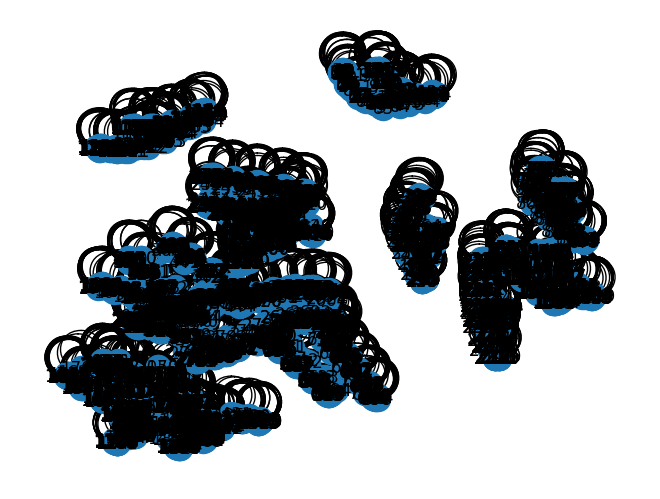

In [16]:
# Plot first batch

nx.draw(G, with_labels=True)

---

# Create Graphs

This will take a while, and i dont even know if it is going to work. jejeje

In [66]:
importlib.reload(models)

<module 'models' from 'c:\\Users\\jalvarez\\Documents\\Code\\GitHubCOde\\Behavioral_Tagging_of_Mice_in_multiple_Mice_dataset_using_Deep_Learning\\src\\models.py'>

In [67]:
len(dataset)

155042

In [68]:
def concatenate_per_graph(embbed, batch):
    ''' Concatenate the embeddings per graph '''
    out = []
    for i in range(batch.max()+1):
        out.append(embbed[batch==i].flatten())
    return out

In [69]:
for data in train_loader:
    a = data
    break

In [70]:
a

DataBatch(x=[5760, 4], edge_index=[2, 59968], file=[32], frame_mask=[5760], behaviour=[32], batch=[5760], ptr=[33])

In [71]:
a.frame_mask.unique()

tensor([ 128,  129,  130,  131,  132,  348,  349,  350,  351,  352,  405,  406,
         407,  408,  409,  410,  411,  412,  430,  431,  432,  433,  434,  546,
         547,  548,  549,  550,  716,  717,  718,  719,  720,  728,  729,  730,
         731,  732, 1017, 1018, 1019, 1020, 1021, 1226, 1227, 1228, 1229, 1230,
        1288, 1289, 1290, 1291, 1292, 1332, 1333, 1334, 1335, 1336, 1345, 1346,
        1347, 1348, 1349, 1403, 1404, 1405, 1406, 1407, 1552, 1553, 1554, 1555,
        1556, 1742, 1743, 1744, 1745, 1746, 1772, 1773, 1774, 1775, 1776, 1835,
        1836, 1837, 1838, 1839, 1978, 1979, 1980, 1981, 1982, 2064, 2065, 2066,
        2067, 2068, 2153, 2154, 2155, 2156, 2157, 2161, 2162, 2163, 2164, 2165,
        2252, 2253, 2254, 2255, 2256, 2257, 2258, 2259, 2260, 2261, 2262, 2263,
        2264, 2265, 2266, 2276, 2277, 2278, 2279, 2280, 2340, 2341, 2342, 2343,
        2344, 2387, 2388, 2389, 2390, 2391, 2393, 2394, 2395, 2396, 2397, 2545,
        2546, 2547, 2548, 2549, 2635, 26

### Graph Classifier

In [72]:
graphencoder = models.GATEncoder(nout = 64, nhid=32, attention_hidden=2, n_in=4, dropout=0.5)
class_head = models.ClassificationHead(n_latent=64, nhid = 32, nout = 2)

In [73]:
lat = graphencoder(a.x, a.edge_index, a.frame_mask)

In [74]:
lat.shape

torch.Size([5760, 64])

In [75]:
# Per node frame-level aggragation
embbed = global_mean_pool(lat, a.batch)

In [76]:
embbed.shape

torch.Size([32, 64])

In [77]:
out = class_head(embbed)

In [78]:
out.shape

torch.Size([32, 2])

In [79]:
model = models.GraphClassifier(graphencoder, class_head)

In [80]:
out = model(a)

In [81]:
out.shape

torch.Size([32, 2])

In [82]:
print('The model has %d trainable parameters' % sum(p.numel() for p in model.parameters() if p.requires_grad))

The model has 11362 trainable parameters


In [83]:
import tqdm

#### Trainning Loop

In [86]:
# Trainning loop
num_epochs = 10
lr = 0.01
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()
writer = SummaryWriter(log_dir='runs/GAT_without_softmax')  # TensorBoard writer

In [87]:

# Training Loop
for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    correct = 0
    total = 1
    i = 0

    for data in tqdm.tqdm(train_loader):
        optimizer.zero_grad()
        outputs = model(data)
        labels = data.behaviour
    
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    
        train_loss += loss.item()
        predicted = outputs.argmax(dim=1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)
        # Log training loss and accuracy at each step
        if i % 10 == 0:  # Log every 10 iterations, adjust as needed
            writer.add_scalar('Loss/Train', loss.item(), epoch * len(train_loader) + i)
            writer.add_scalar('Accuracy/Train', correct / total, epoch * len(train_loader) + i)
            #print(f"Epoch {epoch+1}, Step {i}, Loss: {loss.item()}, Accuracy: {correct / total}")
        i += 1

    train_accuracy = correct / total
    avg_train_loss = train_loss / len(train_loader)
    print(f"Epoch {epoch+1}, Training Loss: {avg_train_loss}, Training Accuracy: {train_accuracy}")

    # Validation phase
    model.eval()
    val_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for val_data in tqdm.tqdm(test_loader):
            val_outputs = model(val_data)
            val_labels = val_data.behaviour
            val_loss += criterion(val_outputs, val_labels).item()
            val_predicted = val_outputs.argmax(dim=1)
            correct += (val_predicted == val_labels).sum().item()
            total += val_labels.size(0)
    
    val_accuracy = correct / total
    avg_val_loss = val_loss / len(test_loader)
    
    print(f"Validation Loss: {avg_val_loss}, Validation Accuracy: {val_accuracy}")

    # Log validation metrics
    writer.add_scalar('Loss/Validation', avg_val_loss, epoch)
    writer.add_scalar('Accuracy/Validation', val_accuracy, epoch)

# Close the TensorBoard writer
writer.close()

100%|██████████| 3877/3877 [12:06<00:00,  5.34it/s]


Epoch 1, Training Loss: 0.5751120571180629, Training Accuracy: 0.6879162165212764


100%|██████████| 970/970 [01:22<00:00, 11.70it/s]


Validation Loss: 0.5189335754544464, Validation Accuracy: 0.7231771421200297


100%|██████████| 3877/3877 [12:29<00:00,  5.18it/s]


Epoch 2, Training Loss: 0.5070850738267293, Training Accuracy: 0.7372333392456907


100%|██████████| 970/970 [01:22<00:00, 11.73it/s]


Validation Loss: 0.5001929746767909, Validation Accuracy: 0.746654197168564


100%|██████████| 3877/3877 [12:40<00:00,  5.10it/s] 


Epoch 3, Training Loss: 0.4985241399064702, Training Accuracy: 0.7440782366125417


100%|██████████| 970/970 [01:21<00:00, 11.84it/s]


Validation Loss: 0.508154523249754, Validation Accuracy: 0.7334322293527685


100%|██████████| 3877/3877 [12:43<00:00,  5.08it/s]


Epoch 4, Training Loss: 0.4931055192391467, Training Accuracy: 0.7489398068271603


100%|██████████| 970/970 [01:22<00:00, 11.80it/s]


Validation Loss: 0.5294191113759562, Validation Accuracy: 0.7496855751556


100%|██████████| 3877/3877 [12:57<00:00,  4.99it/s]


Epoch 5, Training Loss: 0.49115145824098205, Training Accuracy: 0.7507215763419708


100%|██████████| 970/970 [01:22<00:00, 11.74it/s]


Validation Loss: 0.5782340068485319, Validation Accuracy: 0.7250475668354349


 22%|██▏       | 858/3877 [02:54<14:37,  3.44it/s]

---

---

---

---

---

---

---

#### eDIT NAMES

In [23]:
path = r'c:\Users\jalvarez\Documents\Data\DEEPLABCUT_needs_this_folder_I_dont_like_dlc'

# replace ' ' by '_'
for filename in os.listdir(path):
    os.rename(os.path.join(path, filename), os.path.join(path, filename.replace(' ', '_')))

---

In [48]:
import pandas as pd

In [54]:
data_dlc = DataDLC.DataDLC(r'c:\Users\jalvarez\Documents\Data\DataLoadaerTESTTSTST\DMD_mal_Test_1DLC_dlcrnetms5_More_BodyPartsJul9shuffle1_740000_el_filtered.h5')

data_dlc.drop_tail_bodyparts()

coords = data_dlc.coords.to_numpy()

In [61]:
coords.shape
# Reshape coords as (n_frames, n_individuals, n_bodyparts, 3)
coords = coords.reshape((coords.shape[0], data_dlc.n_individuals, data_dlc.n_body_parts, 3))

dtype('float64')